TLDR:

Evaluate a northern us location at december solstice.
Plot diffuse irradiance
Implement Rich solar 24V and 24V panels
Look at margins for MPPT turn on


Setup

In [102]:
import pvmismatch
from pvlib import pvsystem, location, solarposition, ivtools
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import dates

For the 24V Rich Solar Panel, based on its datasheet, the closest CEC database entry is "JA Solar JAM5(L)-72-200/SI" which is keyed in the database as `'JA_Solar_JAM5_L__72_200_SI'`.

For the 24V Rich Solar Panel, there isn't a close entry.  For that panel, we'll scale the appropriate parameters and then use pvlib to calculate the rest.


In [103]:
# Get the module parameters from the CEC database
MODULE_24 = pvsystem.retrieve_sam('CECMod')['JA_Solar_JAM5_L__72_200_SI']
print(MODULE_24)
# Copy the paramters we will need to a new dictionary
rich_solar_24V_params = {
    'Name' : 'Rich Solar 24V',
    'Technology': 'monoSI',
    #'Bifacial' : MODULE_24['Bifacial'],
    #'STC' : MODULE_24['STC'],
    #'PTC' : MODULE_24['PTC'],
    #'A_c' : MODULE_24['A_c'],
    #'Length' : MODULE_24['Length'],
    #'Width' : MODULE_24['Width'],
    'N_s' : MODULE_24['N_s'],
    'I_sc_ref' : MODULE_24['I_sc_ref'],
    'V_oc_ref' : MODULE_24['V_oc_ref'],
    'I_mp_ref' : MODULE_24['I_mp_ref'],
    'V_mp_ref' : MODULE_24['V_mp_ref'],
    'alpha_sc' : MODULE_24['alpha_sc'],
    'beta_oc' : MODULE_24['beta_oc'],
    'gamma_r' : MODULE_24['gamma_r'],
    #'T_NOCT' : MODULE_24['T_NOCT'],
    'a_ref' : MODULE_24['a_ref'],
    'I_L_ref' : MODULE_24['I_L_ref'],
    'I_o_ref' : MODULE_24['I_o_ref'],
    'R_s' : MODULE_24['R_s'],
    'R_sh_ref' : MODULE_24['R_sh_ref'],
    'Adjust' : MODULE_24['Adjust']
}

# Copy and scale the relevant parameters to a new dictionary
rich_solar_12V_params = {
    'Name' : 'Rich Solar 12V',
    'Technology': 'monoSi',
    #'Bifacial' : MODULE_24['Bifacial'],
    #'STC' : MODULE_24['STC']/2,
    #'PTC' : MODULE_24['PTC']/2,
    #'A_c' : MODULE_24['A_c']*2,
    #'Length' : MODULE_24['Length'],
    #'Width' : MODULE_24['Width'],
    'N_s' : MODULE_24['N_s']/2,
    'I_sc_ref' : MODULE_24['I_sc_ref']*2,
    'V_oc_ref' : MODULE_24['V_oc_ref']/2,
    'I_mp_ref' : MODULE_24['I_mp_ref']*2,
    'V_mp_ref' : MODULE_24['V_mp_ref']/2,
    'alpha_sc' : MODULE_24['alpha_sc']*2,
    'beta_oc' : MODULE_24['beta_oc']/2,
    'gamma_r' : MODULE_24['gamma_r']
    # Below will be calculated
    # 'a_ref' : MODULE_24['a_ref'],
    # 'I_L_ref' : MODULE_24['I_L_ref'],
    # 'I_o_ref' : MODULE_24['I_o_ref'],
    # 'R_s' : MODULE_24['R_s'],
    # 'R_sh_ref' : MODULE_24['R_sh_ref'],
    # 'Adjust' : MODULE_24['Adjust'],
}

# Caculate the parameters we don't have for the 12V module
I_L_ref, I_o_ref, R_s, R_sh_ref, a_ref, Adjust = ivtools.sdm.fit_cec_sam(celltype=rich_solar_12V_params['Technology'],
                                                                         v_mp=rich_solar_12V_params['V_mp_ref'],
                                                                         i_mp=rich_solar_12V_params['I_mp_ref'],
                                                                         v_oc=rich_solar_12V_params['V_oc_ref'],
                                                                         i_sc=rich_solar_12V_params['I_sc_ref'],
                                                                         alpha_sc=rich_solar_12V_params['alpha_sc'],
                                                                         beta_voc=rich_solar_12V_params['beta_oc'],
                                                                         gamma_pmp=rich_solar_12V_params['gamma_r'],
                                                                         cells_in_series=rich_solar_12V_params['N_s'])

# Add the calculated parameters to the dictionary
rich_solar_12V_params['a_ref'] = a_ref
rich_solar_12V_params['I_L_ref'] = I_L_ref
rich_solar_12V_params['I_o_ref'] = I_o_ref
rich_solar_12V_params['R_s'] = R_s
rich_solar_12V_params['R_sh_ref'] = R_sh_ref
rich_solar_12V_params['Adjust'] = Adjust

# Add a few more constants
EgRef = 1.121 #The energy bandgap at reference temperature in units of eV. 1.121 eV for crystalline silicon.
dEgdT = -0.0002677 #The temperature dependence of the energy bandgap at reference conditions in units of 1/K. -0.0002677 1/K for crystalline silicon.
Temp = 25 #Cell temperature in degrees C
#TODO we should base this on the average december soltice temperature for the location


Technology            Mono-c-Si
Bifacial                      0
STC                    200.0862
PTC                       178.5
A_c                       1.277
Length                     1.58
Width                     0.808
N_s                          72
I_sc_ref                   5.66
V_oc_ref                  45.62
I_mp_ref                   5.37
V_mp_ref                  37.26
alpha_sc               0.003481
beta_oc               -0.160856
T_NOCT                     47.6
a_ref                  1.947605
I_L_ref                5.720156
I_o_ref                     0.0
R_s                    0.490811
R_sh_ref             789.011169
Adjust                 7.668952
gamma_r                 -0.4567
BIPV                          N
Version       SAM 2018.11.11 r2
Date                   1/3/2019
Name: JA_Solar_JAM5_L__72_200_SI, dtype: object


Next we will use the desoto model to calculate the parameters for the different irradiance levels.

In [104]:
cases = [
    #(1000, Temp),
    #(800, Temp),
    #(600, Temp),
    (400, Temp),
    (200, Temp),
    (100, Temp),
    (50, Temp),
    (25, Temp),
]

conditions = pd.DataFrame(cases, columns=['Geff', 'Tcell'])

IL, I0, Rs, Rsh, nNsVth = pvsystem.calcparams_desoto(
    conditions['Geff'],
    conditions['Tcell'],
    alpha_sc=rich_solar_24V_params['alpha_sc'],
    a_ref=rich_solar_24V_params['a_ref'],
    I_L_ref=rich_solar_24V_params['I_L_ref'],
    I_o_ref=rich_solar_24V_params['I_o_ref'],
    R_sh_ref=rich_solar_24V_params['R_sh_ref'],
    R_s=rich_solar_24V_params['R_s'],
    EgRef=EgRef, 
    dEgdT=-dEgdT
)

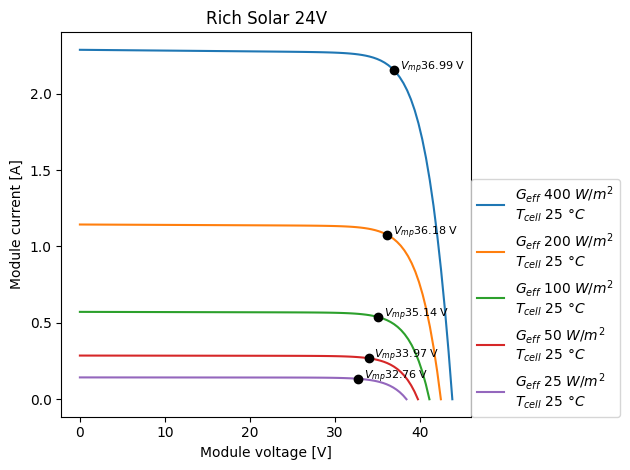

In [105]:
# plug the parameters into the SDE and solve for IV curves:
SDE_params = {
    'photocurrent': IL,
    'saturation_current': I0,
    'resistance_series': Rs,
    'resistance_shunt': Rsh,
    'nNsVth': nNsVth
}
curve_info = pvsystem.singlediode(method='lambertw', **SDE_params)
v = pd.DataFrame(np.linspace(0., curve_info['v_oc'], 100))
i = pd.DataFrame(pvsystem.i_from_v(voltage=v, method='lambertw', **SDE_params))

# plot the calculated curves:
plt.figure()
for idx, case in conditions.iterrows():
    label = (
        "$G_{eff}$ " + f"{case['Geff']} $W/m^2$\n"
        "$T_{cell}$ " + f"{case['Tcell']} $\\degree C$"
    )
    plt.plot(v[idx], i[idx], label=label)
    v_mp = curve_info['v_mp'][idx]
    i_mp = curve_info['i_mp'][idx]
    # mark the MPP
    plt.plot([v_mp], [i_mp], ls='', marker='o', c='k')
    plt.text(v_mp * 1.02, i_mp, f"$V_{{mp}}${v_mp:.2f} V", fontsize=8)

plt.legend(loc=(1.0, 0))
plt.xlabel('Module voltage [V]')
plt.ylabel('Module current [A]')
plt.title(rich_solar_24V_params['Name'])
plt.gcf().set_tight_layout(True)


A function to plot diffuse and direct POA

/tmp/ipykernel_518/3908915229.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sunrise = sunrise_sunset['sunrise'][0]
/tmp/ipykernel_518/3908915229.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sunset = sunrise_sunset['sunset'][0]


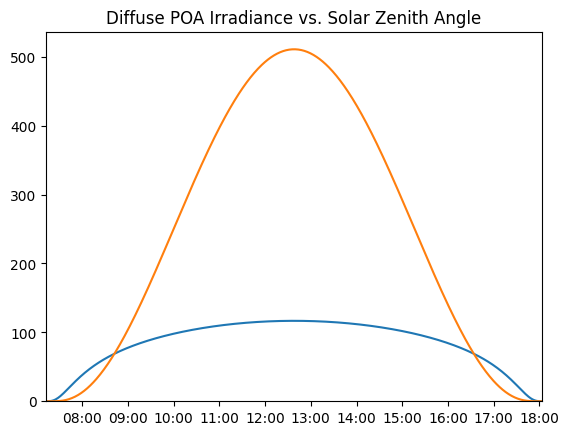

In [106]:
def plot_diffuse_POA():
    surface_tilt = 0
    sigsbee = location.Location(24.5833, -81.767, 'US/Eastern', 0, 'Sigsbee Park')
    times = pd.date_range(start='2024-01-20 00:01', 
                          end='2024-01-20 23:59', 
                          freq='1min', 
                          tz=sigsbee.tz)
    sunrise_sunset = sigsbee.get_sun_rise_set_transit(times, method='spa')

    sunrise = sunrise_sunset['sunrise'][0]
    sunset = sunrise_sunset['sunset'][0]
    times = pd.date_range(start=sunrise, 
                          end=sunset, 
                          freq='1min', 
                          tz=sigsbee.tz)
    cs = sigsbee.get_clearsky(times)
    solpos = sigsbee.get_solarposition(times)
    pvSys = pvsystem.PVSystem(surface_tilt=surface_tilt)
    irradiance = pvSys.get_irradiance(solpos['zenith'], 
                                      solpos['azimuth'], 
                                      cs['ghi'], 
                                      cs['dni'], 
                                      cs['dhi'])
    plt.figure()
    plt.title('Diffuse POA Irradiance vs. Solar Zenith Angle')
    ax = plt.plot(times,irradiance['poa_diffuse'])
    plt.plot(times,irradiance['poa_direct'])
    date_form = dates.DateFormatter("%H:%M", tz=sigsbee.tz)
    ax = plt.gca()
    ax.xaxis.set_major_formatter(date_form)
    plt.xlim(sunrise, sunset)
    plt.ylim(0)
    plt.show()

plot_diffuse_POA()

## Factcheck: Panel Voltage is a Function Incident Light - True in a irrelevant way

It is commonly stated in posts related to solar panels that 

>Connecting your solar panels in series is often preferred if you’re able to spend most of your time in unshaded locations. The main reason for this is that your solar panel system will be more efficient and will perform better at the beginning and end of the day and when it’s cloudy. Here’s why.
>
>Batteries require a higher voltage than their nominal voltage to charge. For example, our lithium batteries need 14.4 volts to start charging. Most solar panels in the 100-watt range have an output voltage between 18-20 volts. To reach the 14.4 volts required to charge your batteries, solar panels in parallel would need to be operating at 75% capacity or more. - [Battleborn](https://battlebornbatteries.com/solar-panels-in-series-or-parallel/)

While Panel Voltage (both open circuit and max power) depend heavily on panel temperature, the dependance on incident light is negligable except at the lowest levels of light.  This is best shown in a figure produced from this (slightly modified) pvlib [example](https://pvlib-python.readthedocs.io/en/v0.10.3/gallery/iv-modeling/plot_singlediode.html#sphx-glr-gallery-iv-modeling-plot-singlediode-py):

For perspective, at sunrise on a cloudy day, the diffuse light is approximately X.

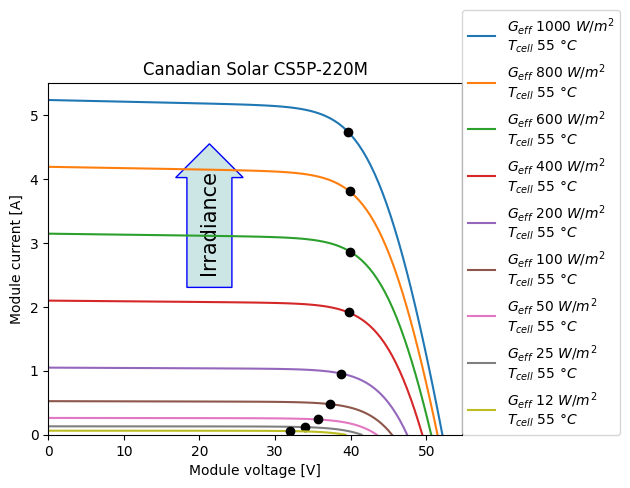

       i_sc       v_oc      i_mp       v_mp        p_mp
0  5.235561  52.129783  4.742475  39.614016  187.868473
1  4.190781  51.483033  3.805721  39.867812  151.725757
2  3.144837  50.649228  2.861983  39.956701  114.355380
3  2.097727  49.474044  1.912108  39.735026   75.977656
4  1.049448  47.465051  0.957075  38.741473   37.078494
5  0.524871  45.456055  0.478155  37.310421   17.840155
6  0.262472  43.447057  0.238622  35.662183    8.509786
7  0.131245  41.438056  0.118991  33.908766    4.034839
8  0.063000  39.310735  0.056913  31.999742    1.821204


In [107]:
# Example module parameters for the Canadian Solar CS5P-220M:
parameters = {
    'Name': 'Canadian Solar CS5P-220M',
    'BIPV': 'N',
    'Date': '10/5/2009',
    'T_NOCT': 42.4,
    'A_c': 1.7,
    'N_s': 96,
    'I_sc_ref': 5.1,
    'V_oc_ref': 59.4,
    'I_mp_ref': 4.69,
    'V_mp_ref': 46.9,
    'alpha_sc': 0.004539,
    'beta_oc': -0.22216,
    'a_ref': 2.6373,
    'I_L_ref': 5.114,
    'I_o_ref': 8.196e-10,
    'R_s': 1.065,
    'R_sh_ref': 381.68,
    'Adjust': 8.7,
    'gamma_r': -0.476,
    'Version': 'MM106',
    'PTC': 200.1,
    'Technology': 'Mono-c-Si',
}

cases = [
    (1000, 55),
    (800, 55),
    (600, 55),
    (400, 55),
    (200, 55),
    (100, 55),
    (50, 55),
    (25, 55),
    (12, 55)
]

conditions = pd.DataFrame(cases, columns=['Geff', 'Tcell'])

# adjust the reference parameters according to the operating
# conditions using the De Soto model:
IL, I0, Rs, Rsh, nNsVth = pvsystem.calcparams_desoto(
    conditions['Geff'],
    conditions['Tcell'],
    alpha_sc=parameters['alpha_sc'],
    a_ref=parameters['a_ref'],
    I_L_ref=parameters['I_L_ref'],
    I_o_ref=parameters['I_o_ref'],
    R_sh_ref=parameters['R_sh_ref'],
    R_s=parameters['R_s'],
    EgRef=1.121,
    dEgdT=-0.0002677
)

# plug the parameters into the SDE and solve for IV curves:
SDE_params = {
    'photocurrent': IL,
    'saturation_current': I0,
    'resistance_series': Rs,
    'resistance_shunt': Rsh,
    'nNsVth': nNsVth
}
curve_info = pvsystem.singlediode(method='lambertw', **SDE_params)
v = pd.DataFrame(np.linspace(0., curve_info['v_oc'], 100))
i = pd.DataFrame(pvsystem.i_from_v(voltage=v, method='lambertw', **SDE_params))

# plot the calculated curves:
plt.figure()
for idx, case in conditions.iterrows():
    label = (
        "$G_{eff}$ " + f"{case['Geff']} $W/m^2$\n"
        "$T_{cell}$ " + f"{case['Tcell']} $\\degree C$"
    )
    plt.plot(v[idx], i[idx], label=label)
    v_mp = curve_info['v_mp'][idx]
    i_mp = curve_info['i_mp'][idx]
    # mark the MPP
    plt.plot([v_mp], [i_mp], ls='', marker='o', c='k')

plt.legend(loc=(1.0, 0))
plt.xlabel('Module voltage [V]')
plt.ylabel('Module current [A]')
plt.xlim(0)
plt.ylim(0)
plt.title(parameters['Name'])
plt.gcf().set_tight_layout(True)


# draw trend arrows
def draw_arrow(ax, label, x0, y0, rotation, size, direction):
    style = direction + 'arrow'
    bbox_props = dict(boxstyle=style, fc=(0.8, 0.9, 0.9), ec="b", lw=1)
    t = ax.text(x0, y0, label, ha="left", va="bottom", rotation=rotation,
                size=size, bbox=bbox_props, zorder=-1)

    bb = t.get_bbox_patch()
    bb.set_boxstyle(style, pad=0.6)


ax = plt.gca()
draw_arrow(ax, 'Irradiance', 20, 2.5, 90, 15, 'r')
# draw_arrow(ax, 'Temperature', 35, 1, 0, 15, 'l')
plt.show()

print(pd.DataFrame({
    'i_sc': curve_info['i_sc'],
    'v_oc': curve_info['v_oc'],
    'i_mp': curve_info['i_mp'],
    'v_mp': curve_info['v_mp'],
    'p_mp': curve_info['p_mp'],
}))